In [1]:
%load_ext autoreload
%autoreload 2

import sys 
from os import getcwd, path
import os
sys.path.append(path.dirname(getcwd()))
import matplotlib.pyplot as plt
import seaborn as sb
#import ggplot as ggplot
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import lifelines as ll
import patsy as patsy
import numpy as np
import pandas as pd
import functools
import survivalstan
import stanity
from stancache import stancache, config
%matplotlib inline
from utils import data
from utils import paper
from cohorts.functions import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


INFO:stancache.seed:Setting seed to 1245502385


In [2]:
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
plotly.offline.init_notebook_mode(connected=True)
import plotly.tools as tls
tls.set_credentials_file(username='jackinovik', api_key='ylofynu6jb')

In [3]:
sample_file_dir = '/mnt/checkpoint-trials/bladder/stan_sample_files'
config.set_value(CACHE_DIR='/mnt/checkpoint-trials/bladder/stancache')

INFO:root:Setting CACHE_DIR = /mnt/checkpoint-trials/bladder/stancache


## prep data

In [4]:
## adapted from TCR plots.ipynb
cohort = data.init_cohort(join_with=["tcr_peripheral_a","ensembl_coverage"])

inner join with ensembl_coverage: 25 to 25 rows
inner join with tcr_peripheral_a: 25 to 25 rows
inner join with ensembl_coverage: 25 to 25 rows
inner join with tcr_peripheral_a: 25 to 25 rows
{'dataframe_hash': -7522244498661454348,
 'provenance_file_summary': {u'cohorts': u'0.4.2',
                             u'isovar': u'0.0.6',
                             u'mhctools': u'0.3.1',
                             u'numpy': u'1.11.2',
                             u'pandas': u'0.19.2',
                             u'pyensembl': u'1.0.3',
                             u'scipy': u'0.18.1',
                             u'topiary': u'0.1.0',
                             u'varcode': u'0.5.11'}}


In [5]:
cols, d = cohort.as_dataframe(on={"peripheral_a_clonality": lambda row: row["Clonality"], 
                                  "missense_snv_count": missense_snv_count,
                                 }, return_cols=True)

inner join with ensembl_coverage: 25 to 25 rows
inner join with tcr_peripheral_a: 25 to 25 rows


INFO:pyensembl.sequence_data:Loaded sequence dictionary from /home/jacquelineburos/.cache/pyensembl/GRCh37/ensembl75/Homo_sapiens.GRCh37.75.pep.all.fa.gz.pickle


inner join with ensembl_coverage: 25 to 25 rows


In [6]:
## construct log-transformed / centered missense_snv_count metric
d['missense_snv_per_mb'] = d.missense_snv_count / d.MB
d['log_mut'] = np.log1p(d.missense_snv_count)
d['log_mut_centered'] = d.log_mut - d.log_mut.mean()
d['snv_count_at_median'] = d['missense_snv_count'].apply(
    lambda x: 'above median' if x>=np.median(d['missense_snv_count']) 
    else 'below median'
    )

## define output variables of interest
time_col = 'pfs'
event_col = 'is_progressed_or_deceased'

## reshape to long
dlong = survivalstan.prep_data_long_surv(df = d, time_col = 'pfs', event_col = 'is_progressed_or_deceased')
dlong_os = survivalstan.prep_data_long_surv(df = d, time_col = 'os', event_col = 'is_deceased')

In [7]:
paper.hyper_label_printer(formatter=lambda: paper.float_str(np.median(d['missense_snv_count'])), label='median_snv_per_mb')

{{{median_snv_per_mb:1.03}}}


## fit models

In [8]:
## load stan models
models = survivalstan.utils.read_files('../utils/stan', pattern = "*.stan")

../utils/stan/pem_survival_model_randomwalk_alt.stan
../utils/stan/pem_survival_model_varying_coefs2.stan
../utils/stan/pem_survival_model_randomwalk_custom_coefs_missense_and_neoant_rates.stan
../utils/stan/pem_survival_model_randomwalk_custom_coefs_expressed_missense_and_neoant_mutations.stan
../utils/stan/logistic_model_by_group.stan
../utils/stan/pem_survival_model_varying_coefs4.stan
../utils/stan/pem_survival_model_randomwalk_bspline2.stan
../utils/stan/pem_survival_model_randomwalk2.stan
../utils/stan/pem_survival_model_randomwalk_tvc2.stan
../utils/stan/pem_survival_model_randomwalk_bspline.stan
../utils/stan/pem_survival_model_varying_coefs3.stan
../utils/stan/pem_survival_model_randomwalk.stan
../utils/stan/pem_survival_model_gamma.stan
../utils/stan/pem_survival_model_randomwalk_bspline_est_xi.stan
../utils/stan/pem_survival_model_unstructured_varcoef_hsprior.stan
../utils/stan/pem_survival_model_unstructured_varcoef.stan
../utils/stan/pem_survival_model_randomwalk_tvc.stan


In [9]:
dlong['lt_91_days'] = (dlong['end_time']<=91).astype(int)
dlong['gt_91_days'] = (dlong['end_time']>91).astype(int)

rw2_model_90d = survivalstan.fit_stan_survival_model(
    formula = '~ missense_snv_count:lt_91_days + missense_snv_count:gt_91_days',
    df = dlong,
    timepoint_end_col = 'end_time',
    sample_col = 'patient_id',
    event_col = 'end_failure',
    chains = 4,
    iter = 5000,
    FIT_FUN = stancache.cached_stan_fit,
    model_code = survivalstan.models.pem_survival_model_randomwalk,
    model_cohort = 'random-walk baseline hazard, time-varying HR at 90d',
    sample_file = os.path.join(sample_file_dir, 'pem_survivalmodel_randomwalk_missense_X_91days'),
    control = dict(adapt_delta = 0.95)
)

INFO:stancache.stancache:Step 1: Get compiled model code, possibly from cache
INFO:stancache.stancache:StanModel: cache_filename set to anon_model.cython_0_25_2.model_code_17281568671805165521.pystan_2_14_0_0.stanmodel.pkl
INFO:stancache.stancache:StanModel: Loading result from cache
INFO:stancache.stancache:Step 2: Get posterior draws from model, possibly from cache
INFO:stancache.stancache:sampling: cache_filename set to anon_model.cython_0_25_2.model_code_17281568671805165521.pystan_2_14_0_0.stanfit.chains_4.control_36919514615.data_70834362586.iter_5000.sample_file_4549781914055993204.seed_1245502385.pkl
INFO:stancache.stancache:sampling: Loading result from cache
/home/jacquelineburos/miniconda3/envs/newbladder2/lib/python2.7/site-packages/stanity/psis.py:228: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/home/jacquelineburos/miniconda3/envs/newbladder2/lib/python2.7/site-packages/stanity/psis.py:24

In [10]:
dlong_os['lt_91_days'] = (dlong_os['end_time']<=91).astype(int)
dlong_os['gt_91_days'] = (dlong_os['end_time']>91).astype(int)

rw2_model_90d_os = survivalstan.fit_stan_survival_model(
    formula = '~ missense_snv_count:lt_91_days + missense_snv_count:gt_91_days',
    df = dlong_os,
    timepoint_end_col = 'end_time',
    sample_col = 'patient_id',
    event_col = 'end_failure',
    chains = 4,
    iter = 5000,
    FIT_FUN = stancache.cached_stan_fit,
    model_code = survivalstan.models.pem_survival_model_randomwalk,
    model_cohort = 'random-walk baseline hazard, time-varying HR at 90d',
    sample_file = os.path.join(sample_file_dir, 'pem_survivalmodel_randomwalk_os_missense_X_91days'),
    control = dict(adapt_delta = 0.95)
)


INFO:stancache.stancache:Step 1: Get compiled model code, possibly from cache
INFO:stancache.stancache:StanModel: cache_filename set to anon_model.cython_0_25_2.model_code_17281568671805165521.pystan_2_14_0_0.stanmodel.pkl
INFO:stancache.stancache:StanModel: Loading result from cache
INFO:stancache.stancache:Step 2: Get posterior draws from model, possibly from cache
INFO:stancache.stancache:sampling: cache_filename set to anon_model.cython_0_25_2.model_code_17281568671805165521.pystan_2_14_0_0.stanfit.chains_4.control_36919514615.data_53320118243.iter_5000.sample_file_10609303870534462159.seed_1245502385.pkl
INFO:stancache.stancache:sampling: Loading result from cache


In [11]:

def extract_time_betas(stanmodel, bins=20, element='beta_time', value_name='beta'):
    time_betas = stanmodel['fit'].extract()[element]
    time_betas = pd.DataFrame(time_betas[:,0,:])
    time_betas = pd.melt(time_betas, var_name = 'timepoint_id', value_name=value_name)
    timepoint_data = stanmodel['df'].loc[:,['timepoint_id','end_time']].drop_duplicates()
    time_betas = pd.merge(time_betas, timepoint_data, on = 'timepoint_id')
    time_betas['exp({})'.format(value_name)] = np.exp(time_betas[value_name])
    time_betas['model_cohort'] = stanmodel['model_cohort']
    time_betas['alt_timepoints'] = pd.cut(time_betas['end_time'],
                                          bins=bins,
                                          precision=0,
                                         )
    time_betas['alt_log_timepoints'] = pd.cut(np.log(time_betas['end_time']),
                                             bins=bins,
                                             precision=1,
                                             )
    rename_log_timepoints = np.exp(time_betas['alt_log_timepoints'].cat.categories.str.extract(', ([\d\.]+)\]', expand=False).astype(float)).astype(int)
    rename_timepoints = time_betas['alt_timepoints'].cat.categories.str.extract(', ([\d\.]+)\]', expand=False).astype(float).astype(int)
    time_betas['alt_timepoint_end'] = time_betas['alt_timepoints'].cat.rename_categories(rename_timepoints)
    time_betas['alt_log_timepoint_end'] = time_betas['alt_log_timepoints'].cat.rename_categories(rename_log_timepoints)
    time_betas['90d_post_therapy'] = time_betas.end_time.apply(lambda x: '>90d' if x > 90 else '<=90d')
    return(time_betas)


In [12]:

tvc_model = survivalstan.fit_stan_survival_model(
    formula = '~ missense_snv_count',
    df = dlong,
    timepoint_end_col = 'end_time',
    sample_col = 'patient_id',
    event_col = 'end_failure',
    chains = 4,
    iter = 10000,
    FIT_FUN = stancache.cached_stan_fit,
    model_code = models['pem_survival_model_randomwalk_tvc.stan'],
    model_cohort = 'random-walk prior - randomwalk tvc',
    sample_file = os.path.join(sample_file_dir, 'pem_survivalmodel_randomwalk_missense_tvc'),
    control = dict(adapt_delta = 0.95)
)

tvc_model['time_betas'] = extract_time_betas(tvc_model)


INFO:stancache.stancache:Step 1: Get compiled model code, possibly from cache
INFO:stancache.stancache:StanModel: cache_filename set to anon_model.cython_0_25_2.model_code_15864830649767775393.pystan_2_14_0_0.stanmodel.pkl
INFO:stancache.stancache:StanModel: Loading result from cache
INFO:stancache.stancache:Step 2: Get posterior draws from model, possibly from cache
INFO:stancache.stancache:sampling: cache_filename set to anon_model.cython_0_25_2.model_code_15864830649767775393.pystan_2_14_0_0.stanfit.chains_4.control_36919514615.data_54527093328.iter_10000.sample_file_5067979448445717619.seed_1245502385.pkl
INFO:stancache.stancache:sampling: Loading result from cache


In [13]:
# same tvc model as above, including posterior-predicted values
tvc_model2 = survivalstan.fit_stan_survival_model(
    formula = '~ missense_snv_count',
    df = dlong,
    timepoint_end_col = 'end_time',
    sample_col = 'patient_id',
    event_col = 'end_failure',
    chains = 4,
    iter = 10000,
    FIT_FUN = stancache.cached_stan_fit,
    model_code = survivalstan.models.pem_survival_model_timevarying,
    model_cohort = 'random-walk prior - randomwalk tvc',
    sample_file = os.path.join(sample_file_dir, 'pem_survivalmodel_randomwalk_missense_tvc'),
    control = dict(adapt_delta = 0.95)
)


ppsurv3 = survivalstan.utils.prep_pp_survival_data([tvc_model2], by='snv_count_at_median')

INFO:stancache.stancache:Step 1: Get compiled model code, possibly from cache
INFO:stancache.stancache:StanModel: cache_filename set to anon_model.cython_0_25_2.model_code_9304163442804524267.pystan_2_14_0_0.stanmodel.pkl
INFO:stancache.stancache:StanModel: Loading result from cache
INFO:stancache.stancache:Step 2: Get posterior draws from model, possibly from cache
INFO:stancache.stancache:sampling: cache_filename set to anon_model.cython_0_25_2.model_code_9304163442804524267.pystan_2_14_0_0.stanfit.chains_4.control_36919514615.data_54527093328.iter_10000.sample_file_5067979448445717619.seed_1245502385.pkl
INFO:stancache.stancache:sampling: Loading result from cache


In [14]:
tvc_model2['time_betas'] = extract_time_betas(tvc_model2)


In [15]:
ppsummary3 = ppsurv3.groupby(['snv_count_at_median','event_time'])['survival'].agg({
        '95_lower': lambda x: np.percentile(x, 2.5),
        '95_upper': lambda x: np.percentile(x, 97.5),
        '50_lower': lambda x: np.percentile(x, 25),
        '50_upper': lambda x: np.percentile(x, 75),
        'median': lambda x: np.percentile(x, 50),
    }).reset_index()
ppsummary3.sort_values(['snv_count_at_median','event_time'], inplace=True)

ppsummary_above = ppsummary3.query('snv_count_at_median == "above median"').copy()
ppsummary_below = ppsummary3.query('snv_count_at_median == "below median"').copy()

## revised version of figure (combined, using matplotlib)

{{{figure_timevary6}}}


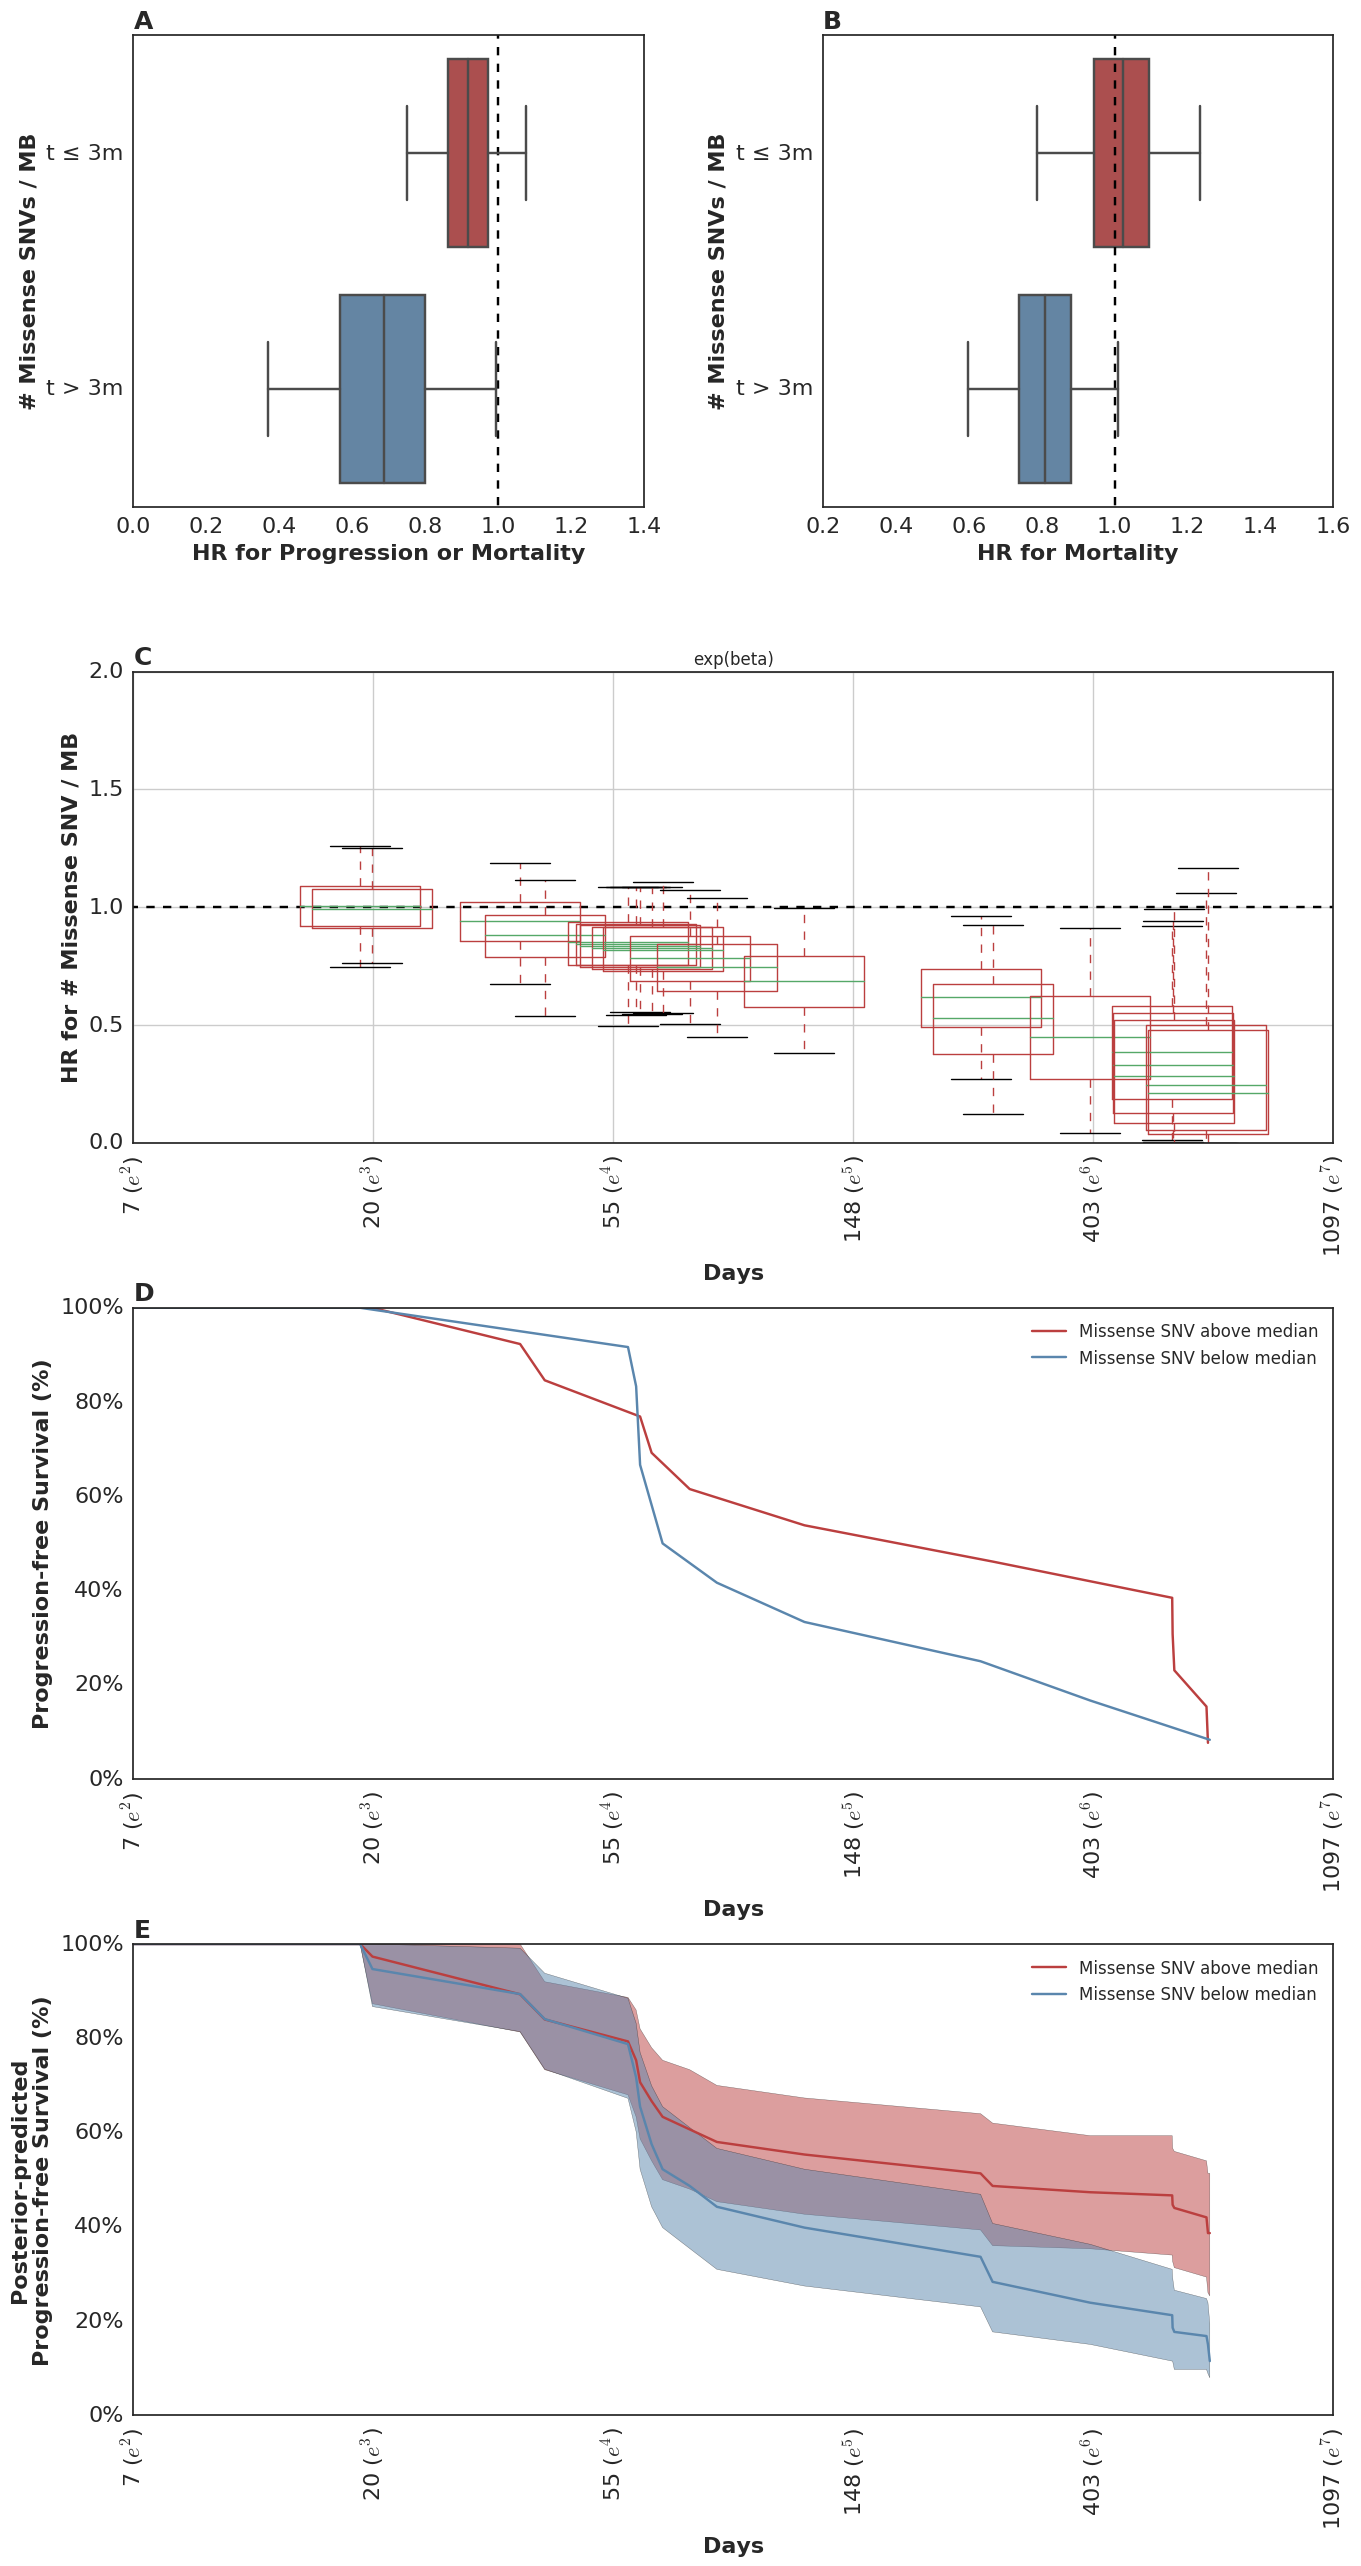

In [16]:
import matplotlib.ticker as mtick


def plot_pp_survival(data,
                     xvar='event_time', yvar='median',
                     y_lower='50_lower', y_upper='50_upper',
                     **kwargs):
    ax = kwargs.pop('ax', plt.gca())
    base_line, = ax.plot(data[xvar], data[yvar]*100, **kwargs)
    ax.fill_between(data[xvar], data[y_lower]*100, data[y_upper]*100, facecolor=base_line.get_color(), alpha=0.5)
    fmt = '%.0f%%' 
    yticks = mtick.FormatStrFormatter(fmt)
    ax.yaxis.set_major_formatter(yticks)
    return ax

def plot_obs_survival(data,
                      **kwargs):
    ax = kwargs.pop('ax', plt.gca())
    observed_surv = survivalstan.utils._summarize_survival(df=data,
                                                           time_col='pfs',
                                                           event_col='is_progressed_or_deceased'
                                                          )
    base_line, = ax.plot(observed_surv['pfs'], observed_surv['survival']*100, **kwargs)
    fmt = '%.0f%%' 
    yticks = mtick.FormatStrFormatter(fmt)
    ax.yaxis.set_major_formatter(yticks)
    return ax



from utils.paper import *
hyper_figure_label_printer("figure_timevary6")

import matplotlib.gridspec as gridspec
fig = plt.figure()
gs1 = gridspec.GridSpec(4, 2)
ax1 = fig.add_subplot(gs1[0])
ax2 = fig.add_subplot(gs1[1])
ax3 = fig.add_subplot(gs1[2:4])
ax4 = fig.add_subplot(gs1[4:6])
ax5 = fig.add_subplot(gs1[6:8])

fig.set_size_inches(2250 / 150, 2625 / 150)

title_loc = "left"
title_fontsize = 18
title_kwargs = {"loc": title_loc, "fontsize": title_fontsize, "fontweight": "bold"}

# prep data for PFS plot
value, variable, coefdata = survivalstan.utils._prep_data_for_coefs([rw2_model_90d], 'coefs')
coefdata['exp(beta)'] = np.exp(coefdata[value])
coefdata['Missense SNV Count / MB'] = coefdata['variable']
result = sb.boxplot(ax=ax1, data=coefdata, x='exp(beta)', y='Missense SNV Count / MB', fliersize=0, whis=[2.5, 97.5])
_ = result.axes.set_yticklabels([u't ≤ 3m', 't > 3m'])
_ = result.axes.vlines(1, -10, 10, linestyles='--')
_ = result.axes.set_ylabel('# Missense SNVs / MB')
_ = result.axes.set_xlabel('HR for {}'.format(cohort.hazard_plot_name))
ax1.set_title("A", **title_kwargs)

# prep data for OS plot
value, variable, coefdata = survivalstan.utils._prep_data_for_coefs([rw2_model_90d_os], 'coefs')
coefdata['exp(beta)'] = np.exp(coefdata[value])
coefdata['Missense SNV Count / MB'] = coefdata['variable']
result = sb.boxplot(ax=ax2, data=coefdata, x='exp(beta)', y='Missense SNV Count / MB', fliersize=0, whis=[2.5, 97.5])
_ = result.axes.set_yticklabels([u't ≤ 3m', 't > 3m'])
_ = result.axes.vlines(1, -10, 10, linestyles='--')
_ = result.axes.set_ylabel('# Missense SNVs / MB')
_ = result.axes.set_xlabel('HR for {}'.format(cohort.hazard_os_plot_name))
ax2.set_title("B", **title_kwargs)

# prep data for time-varying plot
x_min = min(np.log(tvc_model['time_betas'].end_time.drop_duplicates()))
x_max = max(np.log(tvc_model['time_betas'].end_time.drop_duplicates()))
result = time_varying_timepoint_id_overlap_plot = tvc_model['time_betas'].boxplot(
    ax=ax3,
    column='exp(beta)',
    by='end_time',
    whis=[2.5, 97.5],
    positions=np.log(tvc_model['time_betas'].end_time.drop_duplicates()),
)
_ = result.axes.set_ylim([0, 2])
_ = result.axes.hlines(1, -1, 20, linestyles='--')
_ = result.axes.set_xlabel('Days')
_ = result.axes.set_ylabel('HR for # Missense SNV / MB')
_ = time_varying_timepoint_id_overlap_plot.xaxis.set_ticks([2, 3, 4, 5, 6, 7])
_ = time_varying_timepoint_id_overlap_plot.xaxis.set_ticklabels(
    [r"%d ($e^%d$) " % (int(round(np.exp(x))), x) for x in [2, 3, 4, 5, 6, 7]], rotation="vertical")
ax3.set_title("C", **title_kwargs)


# observed survival plot
obs_above = plot_obs_survival(data=d.query('snv_count_at_median == "above median"'),
                              label='Missense SNV above median',
                              ax=ax4)
obs_below = plot_obs_survival(data=d.query('snv_count_at_median == "below median"'),
                              label='Missense SNV below median',
                              ax=ax4)
obs_above.set_xscale("log", nonposx='clip')
obs_below.set_xscale("log", nonposx='clip')
_ = obs_above.axes.set_ylabel('Progression-free Survival (%)')
_ = obs_above.axes.set_xlabel('Days')
_ = obs_above.xaxis.set_ticks(np.exp([2, 3, 4, 5, 6, 7]))
_ = obs_above.xaxis.set_ticklabels(
    [r"%d ($e^%d$) " % (int(round(np.exp(x))), x) for x in [2, 3, 4, 5, 6, 7]], rotation="vertical")
_ = ax4.legend()
ax4.set_title("D", **title_kwargs)


# posterior-predicted survival plot
above = plot_pp_survival(data=ppsummary_above,
                      label='Missense SNV above median',
                      ax=ax5)
below = plot_pp_survival(data=ppsummary_below,
                      label='Missense SNV below median',
                      ax=ax5)
above.set_xscale("log", nonposx='clip')
below.set_xscale("log", nonposx='clip')
_ = above.axes.set_ylabel('Posterior-predicted\nProgression-free Survival (%)')
_ = above.axes.set_xlabel('Days')
_ = above.xaxis.set_ticks(np.exp([2, 3, 4, 5, 6, 7]))
_ = above.xaxis.set_ticklabels(
    [r"%d ($e^%d$) " % (int(round(np.exp(x))), x) for x in [2, 3, 4, 5, 6, 7]], rotation="vertical")
_ = ax5.legend()
ax5.set_title("E", **title_kwargs)

# adjusting subplot spacing  
plt.subplots_adjust(bottom=-0.5, wspace=0.35, hspace=0.35)
fig.suptitle('')

# save to file
fig.savefig(path.join(data.REPO_DATA_DIR, 'Fig3v5.tif'), format='tif', dpi=300, bbox_inches='tight')


In [17]:
from utils.paper import resize_image_plos
resize_image_plos('Fig3v5.tif', 'Fig3v5.tif', height=2000, figure_path=data.REPO_DATA_DIR)